In [1]:
import numpy as np
from sumolib import checkBinary
import math
import random
import time
import traci
import os
import sys
import psutil
import optparse
import keras
import tensorflow as tf 
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

from keras.models import Model
from keras.layers import Input,Dense,Dropout,dot,Flatten

os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

# %matplotlib notebook
# plt.rcParams['animation.html'] = 'jshtml'

Using TensorFlow backend.


# Vehicle class

In [2]:
class Vehicle:
    def __init__(self,vid,waiting_time,vtype):
        self.vid=vid
        self.waiting_time=waiting_time
        self.vtype=vtype

# Environment

In [4]:
class Sumo:
    
    RedYellowGreenStates=["rrgrrGGrrrgrrGGr","rGGrrrgrrGGrrrgr","rrgrrrgrrrgrGGGG","GGGGrrgrrrgrrrgr","rrgrGGGGrrgrrrgr","rrgrrrgrGGGGrrgr","GrGrrrGrGrGrrrGr","rrGrGrGrrrGrGrGr"]
    
    def __init__(self,K,Z):
        self.K=K # K,Z are tunable constants
        self.Z=Z
        self.nearby_vehicles=[[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
        self.count=0
        if 'SUMO_HOME' in os.environ:
            tools=os.path.join(os.environ['SUMO_HOME'],'tools')
            sys.path.append(tools)
   
        else: 
            sys.exit("please declare environment variable 'SUMO_HOME'")
            
    def getSumoBinary(self):

        sumoBinary = checkBinary('sumo-gui')
        return sumoBinary
    
    def getState(self):
        incomming_state=np.zeros([12,3]) # definition of a one row is (number of vehicles in that lane,maximum waiting time,emergency or not)
        outgoing_state=np.ones(4) #will get the negetive impact of this [Left,Right,Bottom,Top]
        for i in range(1,5):
            for j in range(0,3):
                all_vehicles_on_lane = traci.lane.getLastStepVehicleIDs(str(i)+"si_"+str(j))
                
                for vehicle in self.nearby_vehicles[i-1][j]:# removing the vehicle from the memory which has went through the junction
                    if vehicle.vid not in all_vehicles_on_lane:
                        nearby_vehicle_on_lane=self.nearby_vehicles[i-1][j]
                        nearby_vehicle_on_lane.remove(vehicle)
                        self.nearby_vehicles[i-1][j]=nearby_vehicle_on_lane
                        
                for vehicle_id in all_vehicles_on_lane:
#                     getLanePosition outputs the position of the vehicle with respect to start end of the lane that is not the junction side
                    if(traci.vehicle.getLanePosition(vehicle_id)>=132):# consider vehicles which is 100M near or less to the junction lan length is 232
                        flag=1
                        for e,vehicle in enumerate(self.nearby_vehicles[i-1][j]):
                            if vehicle.vid==vehicle_id:
                                vehicle.waiting_time+=1
                                vehicle_list=self.nearby_vehicles[i-1][j]
                                vehicle_list[e]=vehicle # replace the old vehicle object with updated one
                                self.nearby_vehicles[i-1][j]=vehicle_list
                                flag=0
                                break
                        if(flag):
                      
                            new_vehicle_obj=Vehicle(vehicle_id,0,traci.vehicle.getTypeID(vehicle_id))
                            nearby_vehicle_on_lane=self.nearby_vehicles[i-1][j]
                            nearby_vehicle_on_lane.append(new_vehicle_obj)
                            self.nearby_vehicles[i-1][j]=nearby_vehicle_on_lane
                            
                #prepairing incomming state          
                emergency_waiting_time=0
                maximum_waiting_time=0
                for vehicle in self.nearby_vehicles[i-1][j]:
                    if vehicle.vtype == "emergency":
                        if vehicle.waiting_time > emergency_waiting_time:
                            emergency_waiting_time = vehicle.waiting_time
                    if vehicle.waiting_time > maximum_waiting_time:
                        maximum_waiting_time = vehicle.waiting_time
                        
                #Scalling state representation
                #maximum waiting time of a vehicle is 100s
                #maximum number of vehicles that can be fit in to 100M range is 17   
                incomming_state[j+(i-1)*3][0] = len(self.nearby_vehicles[i-1][j])/17
                
                if(maximum_waiting_time>100):
                    incomming_state[j+(i-1)*3][1] = 1
                else:
                    incomming_state[j+(i-1)*3][1] = maximum_waiting_time/100
                 
                if(emergency_waiting_time>100):
                    incomming_state[j+(i-1)*3][2] = 1
                else:
                    incomming_state[j+(i-1)*3][2] = emergency_waiting_time/100
                
        
            #prepairing outgoing state      
            for vehicle_id in traci.lane.getLastStepVehicleIDs(str(i)+"o_0"):
                if(traci.vehicle.getLanePosition(vehicle_id) >= 386):#length of an outgoing road is 486M
                    outgoing_state[i-1] = outgoing_state[i-1]-1/17 # - because of to get the negetive impact when the road is blocked
       
            #transforming outgoing state into attention state
            outgoing_state_final=np.ones(12)
            outgoing_state_final[4] = outgoing_state_final[6] = outgoing_state_final[11] = outgoing_state[0]
            outgoing_state_final[1] = outgoing_state_final[8] = outgoing_state_final[9] = outgoing_state[1]
            outgoing_state_final[2] = outgoing_state_final[3] = outgoing_state_final[10] = outgoing_state[2]
            outgoing_state_final[0] = outgoing_state_final[5] = outgoing_state_final[7] = outgoing_state[3]
            
        return [incomming_state.reshape(1,12,3),outgoing_state_final.reshape(1,12,1)]
        
    def changePhase(self,next_phase_index):
        current_phase=traci.trafficlight.getRedYellowGreenState('0')
        next_phase=self.RedYellowGreenStates[next_phase_index]
        
        
        if(next_phase != current_phase):#generate yellow phase
            yellow_phase = ""
            for i in range(0, len(current_phase)):
                if(current_phase[i].lower()=="g" and next_phase[i].lower()=="r"):

                    yellow_phase = yellow_phase+"y"
                else:
                    yellow_phase = yellow_phase+current_phase[i]

            traci.trafficlight.setRedYellowGreenState('0',yellow_phase) #set yellow phase

            for i in range(3): # allow yellow phase for 3 seconds
                traci.simulationStep()
                
        traci.trafficlight.setRedYellowGreenState('0',next_phase)
        return
    
    def reward(self,replayMemory):
        reg_wainting_time = np.array([],dtype='int')
        emg_waiting = np.array([],dtype='int')
        
        #prepairing the distributions
        for experiance in replayMemory.replay_buffer:
            
            traffic_state = experiance[0][0][0]
            reg_wainting_time = np.append(reg_wainting_time,traffic_state[:,1])
            emg_waiting = np.append(emg_waiting,traffic_state[:,2])
            
        #calculating the mean and the variance of the distribution    
        reg_wainting_time_mean =  np.mean(reg_wainting_time)
        reg_wainting_time_variance = np.var(reg_wainting_time)
        
        emg_wainting_time_mean =  np.mean(emg_waiting)
        emg_wainting_time_variance = np.var(emg_waiting)
        
        reward = -((reg_wainting_time_mean + self.K*reg_wainting_time_variance) + self.Z*(emg_wainting_time_mean + self.K*emg_wainting_time_variance)) 
        
        return reward,round(reg_wainting_time_mean*100,2),round(emg_wainting_time_mean*100,2),round(reg_wainting_time_variance*100,2),round(emg_wainting_time_variance*100,2)


# Deep Q-network

In [5]:
def createDQN():
    incomming_vehicles=Input(shape=(12,3))
    outgoing_vehicles=Input(shape=(12,1))
    
    Dense1_out=Dense(20,name="Dense1",activation='relu')(incomming_vehicles)
    Dense2_out=Dense(10,name="Dense2",activation='relu')(Dense1_out)
    Dropout1_out=Dropout(.2,name="Dropout1")(Dense2_out)
    Dense3_out=Dense(5,name="Dense3",activation='relu')(Dropout1_out)
    
    Dense4_out=Dense(1,name="Dense4",activation='relu')(outgoing_vehicles)
    Dot_out=dot([Dense3_out,Dense4_out],axes=1, normalize=False)
    Flatten_out=Flatten()(Dot_out)
    
    Dense5_out=Dense(8,name="Dense5")(Flatten_out)#no activation function for last layer
    
    model = Model(inputs=[incomming_vehicles,outgoing_vehicles], outputs=[Dense5_out])
    model.compile(optimizer="Adam",loss="categorical_crossentropy")
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return model

# Replay Memory

In [6]:
class ReplayMemory:
    def __init__(self,capacity):
        self.capacity=capacity
        self.replay_memory=[]
        self.push_count=0
        self.replay_buffer=[]
    #agent will only recive reaward after the end of an episode.until that we need to buffer the experience before pushing in
    #to the actual replay memory
    #all rewards of the actions within the episode will be equal to the final reward after the episode.
    #also the next state cannot be directly observerd here because it takes time for vehicles to move and actualy become another
    #state after making a decision.So when adding an experience we add next state as none and after the next action we pop the last
    #experiance and add the current state as the last experience next state.
    def addToReplayBuffuer(self,current_state,action):
        if(self.replay_buffer):
            previous_experience=self.replay_buffer.pop()# get the last experience
            previous_experience[3]=current_state #add the current state as the previous experience next state.
            self.replay_buffer.append(previous_experience)
            
        self.replay_buffer.append([current_state,action,None,None])#new experiance without reward and next state
            
    def addToReplay(self,reward):#experience =[state, action, reward, new_state]
        self.replay_buffer.pop()#top experience is useless because it dosent have a next state
        while self.replay_buffer:#add all buffered experience to replay memory
            
            experience=self.replay_buffer.pop()
            experience[2]=reward #same reward will be given to all the experiences withing the episode
            if(len(self.replay_memory)<self.capacity):
                self.replay_memory.append(experience)
            else:
                # replace the oldest  experience with the new one in replay memory
                self.replay_memory[self.push_count%self.capacity]=experience
                self.push_count +=1
            
    def replay(self,replay_batch_size):

        if len(self.replay_memory) < replay_batch_size: 
            return

        replay_samples = random.sample(self.replay_memory, replay_batch_size)
#         print('experience replay....')
        for sample in replay_samples:

            state, action, reward, new_state = sample
            
            target = PolicyNetwork.predict(state)
            
            #only with fixed q targets
            #Q_future = max(TargetNetwork.predict(new_state)[0])
            
            #with double network concept
            best_action_new_state = np.argmax(PolicyNetwork.predict(new_state)[0])
            Q_future = TargetNetwork.predict(new_state)[0][best_action_new_state] 
            #q value for the best action from the target network
            
            
#             print(TargetNetwork.predict(new_state)[0])
            target[0][action] = reward + Q_future * gamma
            PolicyNetwork.fit(state, target, epochs=1, verbose=0)


# Agent

In [7]:
class Agent:
    
    def __init__(self):
        self.step_number=0
        self.tau = .125
        
        
    def getAction(self,state):
        epsilon = math.exp(-1.*self.step_number*epsilon_decay)
        epsilon = max(epsilon_min, epsilon)
        self.step_number+=1
        if np.random.random() < epsilon:
            return np.random.randint(1,action_space)
        else:
            return np.argmax(PolicyNetwork.predict(state)[0])
             
    def update_target_graph(self):
        weights = PolicyNetwork.get_weights()
        target_weights =TargetNetwork.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        TargetNetwork.set_weights(target_weights)    
        

In [10]:
action_space=8 #action is to choose next phase,agent will take an action within last 4seconds of the current phase
minimum_phase_duration=12
PolicyNetwork=createDQN()
PolicyNetwork.summary()
TargetNetwork=createDQN()
#parameaters to be tuned

gamma = 0.85
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.001
learning_rate = 0.005
tau = .125
replay_batch_size = 32
replay_memory_capacity=100000
target_update=10
decisions_per_episode=10
replay_batch_size=256

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 12, 3)        0                                            
__________________________________________________________________________________________________
Dense1 (Dense)                  (None, 12, 20)       80          input_5[0][0]                    
__________________________________________________________________________________________________
Dense2 (Dense)                  (None, 12, 10)       210         Dense1[0][0]                     
__________________________________________________________________________________________________
Dropout1 (Dropout)              (None, 12, 10)       0           Dense2[0][0]                     
__________________________________________________________________________________________________
input_6 (I

# Plot history

In [11]:
def plot(episode_count,history,ylabel,color,label):
    ax.plot(episode_count,history,color=color, label=label)
    ax.set_xlabel('number of episodes')
    ax.set_ylabel(ylabel)
    ax.set_title('Training....')
    fig.canvas.draw()
    

# Training

In [9]:
sumo_env=Sumo(K=1,Z=2)
replayMemory=ReplayMemory(replay_memory_capacity)
agent=Agent()
traci.start([sumo_env.getSumoBinary(), "-c", "cross3ltl.sumocfg", '--start'])
count=1   
decision_count=1
episode_count=[]
regular_waiting_history=[]
emergency_waiting_history=[]
regular_var_history=[]
emergency_var_history=[]
reward_history=[]
episode_no=1

while traci.simulation.getMinExpectedNumber()>0:
  
        traci.simulationStep()
        if(count==12):#agent will make a decision at the 12th second of the current phase
            current_state=sumo_env.getState()
            action=agent.getAction(current_state)
            sumo_env.changePhase(action)
          
            count=1
            
            replayMemory.addToReplayBuffuer(current_state,action)
            
            if(decision_count==decisions_per_episode):
                decision_count=1
                reward,regular_waiting,emergency_waiting,regular_var,emg_var=sumo_env.reward(replayMemory)
                replayMemory.addToReplay(reward)
                agent.update_target_graph()#updating target graph is performed after each episode
                episode_count.append(episode_no)
                episode_no+=1
                
                regular_waiting_history.append(regular_waiting)
                emergency_waiting_history.append(emergency_waiting)
                
                regular_var_history.append(regular_var)
                emergency_var_history.append(emg_var)
                
                reward_history.append(reward)
                
                replayMemory.replay(replay_batch_size)#experience replay is performed after each episode
#                 print('reg_waiting : ',regular_waiting,'emg_waiting : ',emergency_waiting,'reg_var : ',regular_var,'emg_var : ',emg_var,'reward : ',reward_history)
            else:
                decision_count+=1
        else:
            count+=1
            
traci.close()

 Retrying in 1 seconds
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experienc

experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience replay....
experience

KeyboardInterrupt: 

d:\program files\python\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


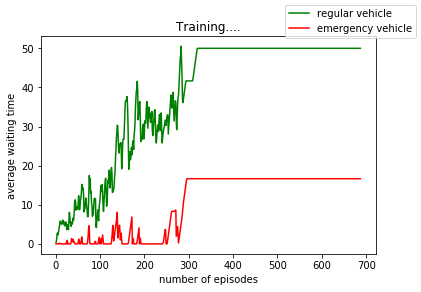

In [10]:
# vehicle average waiting time history
fig=plt.figure()
ax= fig.add_subplot(111)
fig.show()

plot(episode_count,regular_waiting_history,'average waiting time',color='green',label='regular vehicle')
plot(episode_count,emergency_waiting_history,'average waiting time',color='red',label='emergency vehicle')
fig.legend()

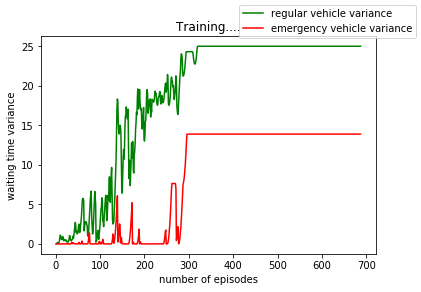

In [11]:
# vehicle waiting time variance history
fig=plt.figure()
ax= fig.add_subplot(111)
fig.show()

plot(episode_count,regular_var_history,'waiting time variance',color='green',label='regular vehicle variance')
plot(episode_count,emergency_var_history,'waiting time variance',color='red',label='emergency vehicle variance')
fig.legend()

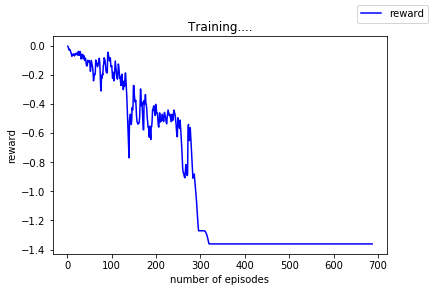

In [12]:
#reward history
fig=plt.figure()
ax= fig.add_subplot(111)
fig.show()

plot(episode_count,reward_history,'reward',color='blue',label='reward')
fig.legend()